In [20]:
import math
from shapely.geometry import shape, Point, LineString, mapping
import numpy as np

import pandas as pd

from collections import OrderedDict
from mpa_sim.services.generate_hex import produce_sites_and_site_areas
from mpa_sim.services.system_simulator import SimulationManager

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [21]:
def generate_receivers(site_area, parameters, grid):
    receivers = []

    if grid == 1:

        geom = shape(site_area[0]['geometry'])
        geom_box = geom.bounds

        minx = geom_box[0]
        miny = geom_box[1]
        maxx = geom_box[2]
        maxy = geom_box[3]

        id_number = 0

        x_axis = np.linspace(
            minx, maxx, num=(
                int(math.sqrt(geom.area) / (math.sqrt(geom.area)/11))
                )
            )
        y_axis = np.linspace(
            miny, maxy, num=(
                int(math.sqrt(geom.area) / (math.sqrt(geom.area)/11))
                )
            )

        xv, yv = np.meshgrid(x_axis, y_axis, sparse=False, indexing='ij')
        for i in range(len(x_axis)):
            for j in range(len(y_axis)):
                receiver = Point((xv[i,j], yv[i,j]))
                indoor_outdoor_probability = np.random.rand(1,1)[0][0]
                if geom.contains(receiver):
                    receivers.append({
                        'type': "Feature",
                        'geometry': {
                            "type": "Point",
                            "coordinates": [xv[i,j], yv[i,j]],
                        },
                        'properties': {
                            'ue_id': "id_{}".format(id_number),
                            "misc_losses": parameters['rx_misc_losses'],
                            "gain": parameters['rx_gain'],
                            "losses": parameters['rx_losses'],
                            "ue_height": float(parameters['rx_height']),
                            "indoor": (True if float(indoor_outdoor_probability) < \
                                float(0.5) else False),
                        }
                    })
                    id_number += 1

                else:
                    pass

    else:

        centroid = shape(site_area[0]['geometry']).centroid

        coord = site_area[0]['geometry']['coordinates'][0][0]
        path = LineString([(coord), (centroid)])
        length = int(path.length)
        increment = int(length / 20)

        indoor = parameters['indoor_users_percentage'] / 100

        id_number = 0
        for increment_value in range(1, 20):
            point = path.interpolate(increment * increment_value)
            indoor_outdoor_probability = np.random.rand(1,1)[0][0]
            receivers.append({
                'type': "Feature",
                'geometry': mapping(point),
                'properties': {
                    'ue_id': "id_{}".format(id_number),
                    "misc_losses": parameters['rx_misc_losses'],
                    "gain": parameters['rx_gain'],
                    "losses": parameters['rx_losses'],
                    "ue_height": float(parameters['rx_height']),
                    "indoor": (True if float(indoor_outdoor_probability) < \
                        float(indoor) else False),
                }
            })
            id_number += 1

    return receivers

In [22]:
def obtain_percentile_values(results, transmission_type, parameters, confidence_intervals):
    output = []

    path_loss_values = []
    received_power_values = []
    interference_values = []
    sinr_values = []
    spectral_efficiency_values = []
    estimated_capacity_values = []
    estimated_capacity_values_km2 = []

    for result in results:

        path_loss_values.append(result['path_loss'])

        received_power_values.append(result['received_power'])

        interference_values.append(result['interference'])

        sinr = result['sinr']
        if sinr == None:
            sinr = 0
        else:
            sinr_values.append(sinr)

        spectral_efficiency = result['spectral_efficiency']
        if spectral_efficiency == None:
            spectral_efficiency = 0
        else:
            spectral_efficiency_values.append(spectral_efficiency)

        estimated_capacity = result['capacity_mbps']
        if estimated_capacity == None:
            estimated_capacity = 0
        else:
            estimated_capacity_values.append(estimated_capacity)

        estimated_capacity_km2 = result['capacity_mbps_km2']
        if estimated_capacity_km2 == None:
            estimated_capacity_km2 = 0
        else:
            estimated_capacity_values_km2.append(estimated_capacity_km2)

    for confidence_interval in confidence_intervals:

        output.append({
            'confidence_interval': confidence_interval,
            'tranmission_type': transmission_type,
            'path_loss': np.percentile(
                path_loss_values, confidence_interval #<- low path loss is better
            ),
            'received_power': np.percentile(
                received_power_values, 100 - confidence_interval
            ),
            'interference': np.percentile(
                interference_values, confidence_interval #<- low interference is better
            ),
            'sinr': np.percentile(
                sinr_values, 100 - confidence_interval
            ),
            'spectral_efficiency': np.percentile(
                spectral_efficiency_values, 100 - confidence_interval
            ),
            'capacity_mbps': np.percentile(
                estimated_capacity_values, 100 - confidence_interval
            ),
            'capacity_mbps_km2': np.percentile(
                estimated_capacity_values_km2, 100 - confidence_interval
            )
        })

    return output


def get_modulation(spectral_efficiency, modulation_and_coding_lut):
    """

    Function to get spectral efficiency and modulation and coding parameters and return the modulation type.
    
    Parameters
    ----------
    spectral_efficiency : float
        Efficiency of information transfer in Bps/Hz.
    modulation_and_coding_lut : list of tuples
        A lookup table containing modulation and coding rates,
        spectral efficiencies and SINR estimates.

    Returns
    -------
    modulation : string
        Type of modulation if exist, otherwise None

    """
    for item in modulation_and_coding_lut:
        if item[5] == spectral_efficiency:
            return item[3]
    return None


In [23]:
def run_simulator(parameters, spectrum_portfolio, ant_types,
    site_radii, modulation_and_coding_lut):
    """

    Function to run the simulator and all associated modules.

    """
    unprojected_point = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': (37.3899962, -121.9757812),
            },
        'properties': {
            'site_id': 'Crystal Palace Radio Tower'
            }
        }

    unprojected_crs = 'epsg:4326'
    projected_crs = 'epsg:3857'

    environments =[
        'urban',
        'suburban',
        'rural'
    ]
    
    temp = []

    for environment in environments:
        for ant_type in ant_types:
            site_radii_generator = site_radii[ant_type]
            for site_radius in site_radii_generator[environment]:
#                 print(site_radius)

                if environment == 'urban' and site_radius > 5000:
                    continue
                if environment == 'suburban' and site_radius > 15000:
                    continue

#                 print('--working on {}: {}'.format(environment, site_radius))

                transmitter, interfering_transmitters, site_area, int_site_areas = \
                    produce_sites_and_site_areas(
                        unprojected_point['geometry']['coordinates'],
                        site_radius,
                        unprojected_crs,
                        projected_crs
                        )

                receivers = generate_receivers(site_area, PARAMETERS, 1)

                for frequency, bandwidth, generation, transmission_type in spectrum_portfolio:

#                     print('{}, {}, {}, {}'.format(frequency, bandwidth, generation, transmission_type))

                    MANAGER = SimulationManager(
                        transmitter, interfering_transmitters, ant_type,
                        receivers, site_area, PARAMETERS
                        )

                    results = MANAGER.estimate_link_budget(
                        frequency,
                        bandwidth,
                        generation,
                        ant_type,
                        transmission_type,
                        environment,
                        modulation_and_coding_lut,
                        parameters
                        )
                    
                    df = pd.DataFrame(results)
                    df = df.assign(
                        environment = environment, 
                        site_radius = site_radius, 
                        frequency = frequency, 
                        bandwidth = bandwidth, 
                        generation = generation, 
                        ant_type = ant_type, 
                        transmission_type = transmission_type,
#                         modulation = get_modulation(df['spectral_efficiency'], modulation_and_coding_lut)
                    )
                    df['modulation'] = df['spectral_efficiency'].apply(lambda se: get_modulation(se, MODULATION_AND_CODING_LUT))
                    temp.append(df)
                    
    return(pd.concat(temp, ignore_index = True))


In [24]:
PARAMETERS = {
    'iterations': 20,
    'seed_value1': 1,
    'seed_value2': 2,
    'indoor_users_percentage': 50,
    'los_breakpoint_m': 500,
    'tx_macro_baseline_height': 30,
    'tx_macro_power': 40,
    'tx_macro_gain': 16,
    'tx_macro_losses': 1,
    'tx_micro_baseline_height': 10,
    'tx_micro_power': 24,
    'tx_micro_gain': 5,
    'tx_micro_losses': 1,
    'rx_gain': 4,
    'rx_losses': 4,
    'rx_misc_losses': 4,
    'rx_height': 1.5,
    'building_height': 5,
    'street_width': 20,
    'above_roof': 0,
    'network_load': 50,
    'percentile': 50,
    'sectorization': 3,
    'mnos': 2,
    'asset_lifetime': 10,
    'discount_rate': 3.5,
    'opex_percentage_of_capex': 10,
    'signaling_overhead': 0.18, # overhead for control channels
    'modulation_compression': True,
    'ru_du_ratio': 4,
    'du_cuup_ratio': 5,
    'cucp_cuup_ratio': 5,
    'compression_ratio': {
        'QPSK': 0.06,
        '16QAM': 0.12,
        '64QAM': 0.18,
        '256QAM': 0.25,
    },
    'Numerology': 1, #µ(0)=15kHz, µ(1)=30kHz, µ(2)=60kHz
    'Bandwidth': 100, #MHz (BW(j))
    'Modulation': 256, #QAM
    # 'Number_of_cells': 4,
    'Number_of_carriers': 1,
    'Number_of_UEs': 64, # per cell
    'DL': 2000, # Mbps per cell
    'UL': 500, # Mbps per cell
    'number_of_aggregated_component_carriers': 1, # (J) max = 16
    'DL_MIMO_Layers': 8, # (v(j)) max = 8 
    'UL_MIMO_Layers': 4, # (v(j)) max = 4
    'MU_MIMO':  1, # Number of Beam with MU-MIMO Users; 
    'Number_of_logical_antenna_ports': 4, # 1/2/4/8/16. Used for fronthaul throughput only, should be higher than MIMO Layers
    'Rmax': 0.92578125, # value depends on the type of coding from 3GPP 38.212 and 3GPP 38.214 (For LDPC code maximum number is 948/1024) 
    'spectral_efficiency': 7.4063, #3GPP TS 38.214 version 15.3.0 Release 15, Table 5.1.3.1-2 (256QAM)
    'Scaling_factor' : 1, # (f(j))
    'DL_UP_ratio': 0.7, #10/14, # based on slot configuration 6:4:4 (6 dl, 4 guard, 4 ul) ref: https://jira.cec.lab.emc.com/browse/MP-4406
    'IQ_mantissa_bitwidth': 8, # per I or per Q
    'IQ_exp_bitwidth': 4,
}

In [25]:
# PARAMETERS = {
#     'iterations': 20,
#     'seed_value1': 1,
#     'seed_value2': 2,
#     'indoor_users_percentage': 50,
#     'los_breakpoint_m': 500,
#     'tx_macro_baseline_height': 30,
#     'tx_macro_power': 40,
#     'tx_macro_gain': 16,
#     'tx_macro_losses': 1,
#     'tx_micro_baseline_height': 10,
#     'tx_micro_power': 24,
#     'tx_micro_gain': 5,
#     'tx_micro_losses': 1,
#     'rx_gain': 4,
#     'rx_losses': 4,
#     'rx_misc_losses': 4,
#     'rx_height': 1.5,
#     'building_height': 5,
#     'street_width': 20,
#     'above_roof': 0,
#     'network_load': 50,
#     'percentile': 50,
#     'sectorization': 3,
#     'mnos': 2,
#     'asset_lifetime': 10,
#     'discount_rate': 3.5,
#     'opex_percentage_of_capex': 10,
#     'signaling_overhead': 0.18, # overhead for control channels
#     'modulation_compression': True,
#     'ru_du_ratio': 4,
#     'du_cuup_ratio': 1,
#     'cucp_cuup_ratio': 1,
#     'compression_ratio': {
#         'QPSK': 0.06,
#         '16QAM': 0.12,
#         '64QAM': 0.18,
#         '256QAM': 0.25,
#     },
#     'Numerology': 1, #µ(0)=15kHz, µ(1)=30kHz, µ(2)=60kHz
#     'Bandwidth': 100, #MHz (BW(j))
#     'Modulation': 256, #QAM
#     # 'Number_of_cells': 4,
#     'Number_of_UEs': 64, # per cell
#     'DL': 2000, # Mbps per cell
#     'UL': 500, # Mbps per cell
#     'number_of_aggregated_component_carriers': 1, # (J) max = 16
#     'DL_MIMO_Layers': 8, # (v(j)) max = 8 
#     'UL_MIMO_Layers': 4, # (v(j)) max = 4
#     'MU_MIMO':  1, # Number of Beam with MU-MIMO Users; 
#     'Number_of_logical_antenna_ports': 4, # 1/2/4/8/16. Used for fronthaul throughput only, should be higher than MIMO Layers
#     'Rmax': 0.92578125, # value depends on the type of coding from 3GPP 38.212 and 3GPP 38.214 (For LDPC code maximum number is 948/1024) 
#     'spectral_efficiency': 7.4063, #3GPP TS 38.214 version 15.3.0 Release 15, Table 5.1.3.1-2 (256QAM)
#     'Scaling_factor' : 1, # (f(j))
#     'DL_UP_ratio': 0.7, #10/14, # based on slot configuration 6:4:4 (6 dl, 4 guard, 4 ul) ref: https://jira.cec.lab.emc.com/browse/MP-4406
#     'IQ_mantissa_bitwidth': 8, # per I or per Q
#     'IQ_exp_bitwidth': 4,
# }

In [26]:
# PARAMETERS = {
#     'iterations': 20,
#     'seed_value1': 1,
#     'seed_value2': 2,
#     'indoor_users_percentage': 50,
#     'los_breakpoint_m': 500,
#     'tx_macro_baseline_height': 30,
#     'tx_macro_power': 40,
#     'tx_macro_gain': 16,
#     'tx_macro_losses': 1,
#     'tx_micro_baseline_height': 10,
#     'tx_micro_power': 24,
#     'tx_micro_gain': 5,
#     'tx_micro_losses': 1,
#     'rx_gain': 4,
#     'rx_losses': 4,
#     'rx_misc_losses': 4,
#     'rx_height': 1.5,
#     'building_height': 5,
#     'street_width': 20,
#     'above_roof': 0,
#     'network_load': 50,
#     'percentile': 50,
#     'sectorization': 3,
#     'mnos': 2,
#     'asset_lifetime': 10,
#     'discount_rate': 3.5,
#     'opex_percentage_of_capex': 10,
#     'signaling_overhead': 0.18, # overhead for control channels
#     'modulation_compression': True,
#     'ru_du_ratio': 10,
#     'du_cu_ratio': 1,
#     'compression_ratio': {
#         'QPSK': 0.06,
#         '16QAM': 0.12,
#         '64QAM': 0.18,
#         '256QAM': 0.25,
#     },
#     'Numerology': 1, #µ(0)=15kHz, µ(1)=30kHz, µ(2)=60kHz
#     'Bandwidth': 100, #MHz (BW(j))
#     'Modulation': 256, #QAM
#     'Number_of_cells': 4,
#     'Number_of_UEs': 64, 
#     'DL': 2000, # Mbps 
#     'UL': 500, # Mbps 
#     'number_of_aggregated_component_carriers': 1, # (J) max = 16
#     'DL_MIMO_Layers': 4, # (v(j)) max = 8 
#     'UL_MIMO_Layers': 4, # (v(j)) max = 4
#     'MU_MIMO':  1, # Number of Beam with MU-MIMO Users; 
#     'Number_of_logical_antenna_ports': 4, # 1/2/4/8/16. Used for fronthaul throughput only, should be higher than MIMO Layers
#     'Rmax': 0.92578125, # value depends on the type of coding from 3GPP 38.212 and 3GPP 38.214 (For LDPC code maximum number is 948/1024) 
#     'spectral_efficiency': 7.4063, #3GPP TS 38.214 version 15.3.0 Release 15, Table 5.1.3.1-2 (256QAM)
#     'Scaling_factor' : 1, # (f(j))
#     'DL_UP_ratio': 0.7, #10/14, # based on slot configuration 6:4:4 (6 dl, 4 guard, 4 ul) ref: https://jira.cec.lab.emc.com/browse/MP-4406
#     'IQ_mantissa_bitwidth': 8, # per I or per Q
#     'IQ_exp_bitwidth': 4,
# }

SPECTRUM_PORTFOLIO = [
    (3.7, 1, '5G', '1x1'),
]

ANT_TYPE = [
    ('macro'),
    ('micro'),
]

MODULATION_AND_CODING_LUT =[
    # ETSI. 2018. ‘5G; NR; Physical Layer Procedures for Data
    # (3GPP TS 38.214 Version 15.3.0 Release 15)’. Valbonne, France: ETSI.
    # Generation MIMO CQI Index	Modulation	Coding rate
    # Spectral efficiency (bps/Hz) SINR estimate (dB)
    ('5G', '8x8', 1, 'QPSK', 78, 0.30, -6.7),
    ('5G', '8x8', 2, 'QPSK', 193, 2.05, -4.7),
    ('5G', '8x8', 3, 'QPSK', 449, 4.42, -2.3),
    ('5G', '8x8', 4, '16QAM', 378, 6.40, 0.2),
    ('5G', '8x8', 5, '16QAM', 490, 8.00, 2.4),
    ('5G', '8x8', 6, '16QAM', 616, 10.82, 4.3),
    ('5G', '8x8', 7, '64QAM', 466, 12.40, 5.9),
    ('5G', '8x8', 8, '64QAM', 567, 16.00, 8.1),
    ('5G', '8x8', 9, '64QAM', 666, 19.00, 10.3),
    ('5G', '8x8', 10, '64QAM', 772, 22.00, 11.7),
    ('5G', '8x8', 11, '64QAM', 873, 28.00, 14.1),
    ('5G', '8x8', 12, '256QAM', 711, 32.00, 16.3),
    ('5G', '8x8', 13, '256QAM', 797, 38.00, 18.7),
    ('5G', '8x8', 14, '256QAM', 885, 44.00, 21),
    ('5G', '8x8', 15, '256QAM', 948, 50.00, 22.7),
]

unprojected_point = {
    'type': 'Feature',
    'geometry': {
        'type': 'Point',
        'coordinates': (37.3899962, -121.9757812), #Great America Parkway, Santa Clara, CA 95054-1231, United States of America
        },
    'properties': {
        'site_id': 'Crystal Palace Radio Tower'
        }
    }



## Cost Model

In [27]:
COSTS = {
    #all costs in $USD
    'cpu': [
        {
            'model': '6148',
            'price': 2988.39,
            'cores': 20,
            'power': 150,
        },
        {
            'model': '6230',
            'price': 1582.72,
            'cores': 26,
            'power': 150,
        },
    ],
    'switch': [
        {
            'model': '10GB Fiber',
            'price': 2000,
            'ports': 8,
            'power': 150,
            'speed': 10, #Gbps
        },
        {
            'model': '25GB Fiber',
            'price': 8000,
            'ports': 8,
            'power': 350,
            'speed': 25, #Gbps
        },
    ],
    'server': [
        {
            'model': 'XR11',
            'price': 900,
            'size': '1U',
            'power': 150,
            'cpu_max': 2,
            'pcie_max': 4,
        },
        {
            'model': 'R750',
            'price': 1700,
            'size': '2U',
            'power': 200,
            'cpu_max': 2,
            'pcie_max': 4,
        },
    ],
    'lease_line_installation': [
        {
            'model': '1Gbps',
            'price': 1000,
            'speed': 1, #Gbps
        },
        {
            'model': '10Gbps',
            'price': 2000,
            'speed': 10, #Gbps
        },        
        {
            'model': '100Gbps',
            'price': 10000,
            'speed': 100, #Gbps
        },
    ],
    'lease_line_installation_per_meter': [
        {
            'model': '1Gbps',
            'price': 0.1,
            'speed': 1, #Gbps
        },
        {
            'model': '10Gbps',
            'price': 0.2,
            'speed': 10, #Gbps
        },        
        {
            'model': '100Gbps',
            'price': 0.3,
            'speed': 100, #Gbps
        },
    ],
    'lease_line_rental': [
        {
            'model': '1Gbps',
            'price': 500,
            'speed': 1, #Gbps
        },
        {
            'model': '10Gbps',
            'price': 5000,
            'speed': 10, #Gbps
        },        
        {
            'model': '100Gbps',
            'price': 15000,
            'speed': 100, #Gbps
        },
    ],
    'sfp': [
        {
            'model': 'QSPF28',
            'price': 599, #usd
            'distance': 10000, #meters
            'speed': 100, #Gbps
        },
        {
            'model': 'SPF28',
            'price': 420, #usd
            'distance': 30000, #meters
            'speed': 25, #Gbps
        },
        {
            'model': 'Dell SPF',
            'price': 115, #usd
            'distance': 300, #meters
            'speed': 10, #Gbps
        },
    ],
    'single_sector_antenna': [
        {
            'price': 1500
        },
    ],
    'ru': [
        {
            'price': 4000
        },
    ],
    'du': [
        {
            'price': 10000
        },
    ],
    'cu': [
        {
            'price': 15000
        },
    ],
    'tower': [
        {
            'price': 10000
        },
    ],
    'transportation': [
        {
            'price': 10000
        },
    ],
    'installation': [
        {
            'price': 5000
        },
    ],
    'site_rental': [
        {
            'price': 8000
        },
    ],
    'power_generator_battery_system': [
        {
            'price': 5000
        },
    ],
    'smo': [
        {
            'price': 2000
        },
    ],    
    'l1_controller': [
        {
            'model': 'marvell',
            'price': 900,
            'ports': 4,
            'speed': 10, # Gbps
        },
    ],

}


In [28]:
from mpa_sim.services.hw_estimator import CPU_forecasting_model
from mpa_sim.services.costs import Cost

In [29]:
cost_obj = Cost(simulation_parameters = PARAMETERS, cost_parameters = COSTS)
cpu_fm = CPU_forecasting_model(simulation_parameters = PARAMETERS)

In [30]:
frequency, bandwidth, generation, transmission_type = SPECTRUM_PORTFOLIO[0]
ant_type = "macro"
environment = "urban"

site_radius = 500 # meters

Number_of_sits_per_km2 = cost_obj.get_sites_per_km2(site_radius)
Number_of_cells_per_km2 = Number_of_sits_per_km2 * PARAMETERS["sectorization"]
Number_of_ues_per_km2 = Number_of_cells_per_km2 * 64
Number_of_sits_per_km2, Number_of_cells_per_km2, Number_of_ues_per_km2

(1.1547005383792517, 3.4641016151377553, 221.70250336881634)

In [31]:
unprojected_point = {
    'type': 'Feature',
    'geometry': {
        'type': 'Point',
        'coordinates': (37.3899962, -121.9757812),
        },
    'properties': {
        'site_id': 'Crystal Palace Radio Tower'
        }
    }

unprojected_crs = 'epsg:4326'
projected_crs = 'epsg:3857'

In [32]:
transmitter, interfering_transmitters, site_area, int_site_areas = \
    produce_sites_and_site_areas(
        unprojected_point['geometry']['coordinates'],
        site_radius,
        unprojected_crs,
        projected_crs
        )

In [33]:
interferences_x, interferences_y = [], []
for int_trans in interfering_transmitters:
    interferences_x.append(int_trans['geometry']['coordinates'][0])
    interferences_y.append(int_trans['geometry']['coordinates'][1])
receivers = generate_receivers(site_area, PARAMETERS, 1) 

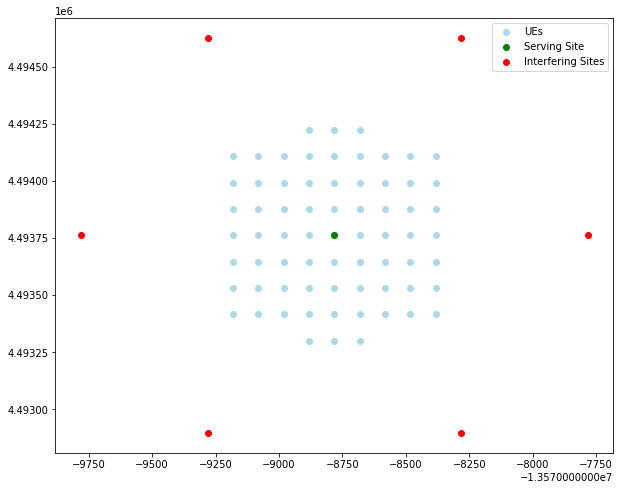

In [34]:
X, Y = [] , []
for r in receivers:
    X.append(r['geometry']['coordinates'][0])
    Y.append(r['geometry']['coordinates'][1])
plt.figure(figsize=(10,8))    
plt.scatter(X,Y, color = 'lightblue', label="UEs")
plt.scatter(transmitter[0]['geometry']['coordinates'][0],transmitter[0]['geometry']['coordinates'][1], color='green', label="Serving Site")
plt.scatter(interferences_x,interferences_y, color = 'red', label="Interfering Sites")
plt.legend()
plt.show()

In [35]:
MANAGER = SimulationManager(
    transmitter, interfering_transmitters, 
    ant_type,
    receivers, site_area, PARAMETERS
    )

results = MANAGER.estimate_link_budget(
    frequency,
    bandwidth,
    generation,
    ant_type,
    transmission_type,
    environment,
    MODULATION_AND_CODING_LUT,
    PARAMETERS
    )

df = pd.DataFrame(results)
df = df.assign(
    environment = environment, 
    site_radius = site_radius, 
    frequency = frequency, 
    bandwidth = bandwidth, 
    generation = generation, 
    ant_type = ant_type, 
    transmission_type = transmission_type,
#                         modulation = get_modulation(df['spectral_efficiency'], modulation_and_coding_lut)
)
df['modulation'] = df['spectral_efficiency'].apply(lambda se: get_modulation(se, MODULATION_AND_CODING_LUT))
df.head(10)

,id,path_loss,r_model,type_of_sight,ave_inf_pl,received_power,distance,interference,i_model,network_load,ave_distance,noise,i_plus_n,tranmission_type,sinr,spectral_efficiency,modulation,capacity_mbps,capacity_mbps_km2,receiver_x,receiver_y,fronthaul_capacity_mbps,signaling_overhead_mbps,environment,site_radius,frequency,bandwidth,generation,ant_type,transmission_type
0,id_0,136,etsi_tr_138_901,nlos,146.000000,-85.0,529.150262,-84.301026,etsi_tr_138_901,50,1071.656829,-112.477229,-84.301026,1x1,-0.7,0.0,None,0.0,0.000000,-1.357918e+07,4.493416e+06,0.0,0.0,urban,500,3.7,1,5G,macro,1x1
1,id_1,102,etsi_tr_138_901,los,146.333333,-51.0,461.880215,-88.000000,etsi_tr_138_901,50,1054.447979,-112.477229,-88.000000,1x1,37.0,50.0,256QAM,50.0,57.735027,-1.357918e+07,4.493531e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
2,id_2,98,etsi_tr_138_901,los,143.166667,-47.0,416.333200,-84.300596,etsi_tr_138_901,50,1043.847826,-112.477229,-84.300596,1x1,37.3,50.0,256QAM,50.0,57.735027,-1.357918e+07,4.493647e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
3,id_3,98,etsi_tr_138_901,los,143.166667,-47.0,400.000000,-83.301030,etsi_tr_138_901,50,1040.259796,-112.477229,-83.301030,1x1,36.3,50.0,256QAM,50.0,57.735027,-1.357918e+07,4.493762e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
4,id_4,98,etsi_tr_138_901,los,143.166667,-47.0,416.333200,-84.300596,etsi_tr_138_901,50,1043.847826,-112.477229,-84.300596,1x1,37.3,50.0,256QAM,50.0,57.735027,-1.357918e+07,4.493878e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
5,id_5,102,etsi_tr_138_901,los,146.333333,-51.0,461.880215,-88.000000,etsi_tr_138_901,50,1054.447979,-112.477229,-88.000000,1x1,37.0,50.0,256QAM,50.0,57.735027,-1.357918e+07,4.493993e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
6,id_6,136,etsi_tr_138_901,nlos,146.000000,-85.0,529.150262,-84.301026,etsi_tr_138_901,50,1071.656829,-112.477229,-84.301026,1x1,-0.7,0.0,None,0.0,0.000000,-1.357918e+07,4.494109e+06,0.0,0.0,urban,500,3.7,1,5G,macro,1x1
7,id_7,99,etsi_tr_138_901,los,143.000000,-48.0,458.257569,-82.301030,etsi_tr_138_901,50,1053.084581,-112.477229,-82.301030,1x1,34.3,50.0,256QAM,50.0,57.735027,-1.357908e+07,4.493416e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
8,id_8,97,etsi_tr_138_901,los,143.000000,-46.0,378.593890,-85.296709,etsi_tr_138_901,50,1036.246230,-112.477229,-85.296709,1x1,39.3,50.0,256QAM,50.0,57.735027,-1.357908e+07,4.493531e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
9,id_9,99,etsi_tr_138_901,los,146.166667,-48.0,321.455025,-89.296708,etsi_tr_138_901,50,1026.030358,-112.477229,-89.296708,1x1,41.3,50.0,256QAM,50.0,57.735027,-1.357908e+07,4.493647e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1


In [36]:
required_DL_capacity_at_ru_mbps = df['fronthaul_capacity_mbps'].sum() + df['signaling_overhead_mbps'].sum()
required_UL_capacity_at_ru_mbps = required_DL_capacity_at_ru_mbps / 4
required_DL_capacity_at_ru_mbps

1397.5

In [37]:
PARAMETERS["Number_of_cells"] = Number_of_cells_per_km2
PARAMETERS["Number_of_UEs"] = Number_of_ues_per_km2
PARAMETERS["DL"] = required_DL_capacity_at_ru_mbps
PARAMETERS["UL"] = required_UL_capacity_at_ru_mbps

In [38]:
model_CU, model_DU, scaler = cpu_fm.loadModels()
res = cpu_fm.estimateCPU_Utilization_CU_DU(model_CU, model_DU, scaler)
res

c:\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMa

{'DU_utils': 1343.5789567577751,
 'CUCP_utils': 8526.47263603598,
 'CUUP_utils': 2762.399063412418}

In [39]:
res = cost_obj.get_cost(
    sites_per_km2 = Number_of_sits_per_km2, 
    capacity_gbps = required_DL_capacity_at_ru_mbps, 
    rudu_distance=15000, 
    ducu_distance=10000,
    CUCP_utils = res['CUCP_utils'], 
    CUUP_utils = res['CUUP_utils'],
    DU_utils = res['DU_utils'])


In [40]:
res['cost_breakdown']

{'single_sector_antenna': 9668.837533402097,
 'ru': 25783.566755738917,
 'tower': 11547.005383792517,
 'transportation': 11547.005383792517,
 'installation': 5773.5026918962585,
 'site_rental': 79514.40196791933,
 'power_generator_battery_system': 10743.152814891215,
 'fiber_switch': 17189.044503825946,
 'sfp_ru': 504.1243297309859,
 'sfp_sectors': 756.1864945964788,
 'eCPRI_leased_line_capex': 31155.143163184523,
 'eCPRI_leased_line_opex': 149089.50368984873,
 'f1u_leased_line_capex': 20949.147989037876,
 'f1u_leased_line_opex': 111817.12776738657,
 'f1c_leased_line_capex': 20949.147989037876,
 'f1c_leased_line_opex': 111817.12776738657,
 'l1_controller': 483.44187667010476,
 'cucp_cpu': 102666.6554628214,
 'cucp_server': 15463.455823027769,
 'cuup_cpu': 33258.908280224634,
 'cuup_server': 5017.14249240532,
 'du_cpu': 16177.321678213166,
 'du_server': 2442.100425153081}

In [41]:
res['components_breakdown']

{'single_sector_antenna': 20.0,
 'ru': 20.0,
 'tower': 6.666666666666667,
 'power_generator_battery_system': 6.666666666666667,
 'fiber_switch': 6.666666666666667,
 'sfp': 40.0,
 'eCPRI_Throughput(Gbps)': 25.9773696,
 'f1u_Throughput(Gbps)': 13751.400000000001,
 'f1c_Throughput(Gbps)': 3018.6,
 'l1_controller': 5.0,
 'cucp_cpu': 106.58090795044976,
 'cucp_server': 53.29045397522488,
 'cuup_cpu': 34.529988292655226,
 'cuup_server': 17.264994146327613,
 'du_cpu': 16.794736959472193,
 'du_server': 8.397368479736096}

In [42]:
total_cost = round(sum(res['cost_breakdown'].values()),2)
print('Cost Per Square Kilometer: ${:5,.2f}'.format(total_cost))
print('Cost Per Square meter: ${:5,.2f}'.format(total_cost/10**6))

Cost Per Square Kilometer: $794,313.05
Cost Per Square meter: $ 0.79


In [43]:
res['components_breakdown']['eCPRI_Throughput(Gbps)']/res['components_breakdown']['ru']

1.2988684799999999

In [44]:
res['components_breakdown']['f1u_Throughput(Gbps)'] + res['components_breakdown']['f1c_Throughput(Gbps)'] 

16770.0